In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as st
import imageio as io

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.stats.multitest import multipletests

In [2]:
img_name = 'images_full/images/modified_100136192_case.bmp'

In [3]:
img_dir = 'images_full/images/'
img_names = np.array(os.listdir(img_dir))
img_ids = [x.split('/')[-1].split('_')[-1][:-4] for x in img_names if x.find('original') != -1]

In [4]:
def phrase2vec(phrase):
    base = np.array([ord(char)-97 for char in list(phrase)])
    size = 4096
    vec = np.concatenate(size*[base])[:size]
    return vec

def get_object(img_id, img_names, img_dir):
    mask = np.array([x.find(img_id) != -1 for x in img_names])
    mod, orig = np.sort(img_names[mask])
    phrase = mod.split('_')[-1][:-4]
    vec = phrase2vec(phrase)
    
    orig_img = np.asarray(io.imread(os.path.join(img_dir, orig)), dtype = int)
    mod_img = np.asarray(io.imread(os.path.join(img_dir, mod)), dtype = int)
    delta_img = mod_img - orig_img
    return (delta_img, vec)

Рассматриваем изображение как последовательность из 4096 наблюдений. При наличии модификации указанным алгоритмом последовательность, соответствующая данной модификации, имеет период, равный длине слова. Период приводит к автокорреляции с соответсвующим лагом. Таким образом, будем искать автокорреляцию ряда для некоторого значения периода. 

По AFC графику ищем локальные максимумы и вычисляем для соответствующих лагов (отвечающих локальным максимумам) Q-тест Льюнг—Бокса (нулевая гипотеза - ряд случаен и соответсвует белому шуму). Проводим поправку Бенджамина-Хохберга и для уровня значимости 1e-5 принимаем решение.

In [5]:
history = dict()
has_cycle = np.zeros(len(img_ids)).astype(bool)
for i, img_id in enumerate(img_ids):
    x, y = get_object(img_id, img_names, img_dir)
    # compute acf for different lags
    acf_vals, _, pvals = acf(x.flatten(), nlags=20, qstat=True)
    # find local maximas (candidates to be cycle periods)
    local_maxima_mask = np.r_[True, acf_vals[1:] > acf_vals[:-1]] & np.r_[acf_vals[:-1] > acf_vals[1:], True]
    local_maxima_pvals = pvals[local_maxima_mask[1:]]
    # benjamini-hochberg
    rejs, local_maxima_pvals_corrected = multipletests(local_maxima_pvals, alpha=1e-5, method='fdr_bh')[:2]
    has_cycle[i] = np.sum(rejs) > 0 # whether to reject that acf coef = 0
    if has_cycle[i]:
        history[img_id] = acf_vals

/Users/highcanarias/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


В условии утверждалось, что для генерации изменения используется либо алгоритм, либо белый шум. Так вот проверяя нулевую гипотезу о том, что данные соответствуют булому шуму, отклонение данной гипотезы позволяет выделить объекты, для которых генерация производилось с использованием алгоритма. 
(то есть, если при генерации изменения использовался алгоритм, то ряд очевидно не случаен. Нулевая гипотеза для него будет отклонена.)

Далее видим, что ровно 1% не случаен и генерен алгоритмом, как и обещалось в задаче. 

In [6]:
print("Ratio of images containing codes: %0.3f" % has_cycle.mean())

Ratio of images containing codes: 0.010


Производим оценку параметра альфа по отобранным картинкам.

In [7]:
hat_alphas = []
cycled_ids = np.array(img_ids)[has_cycle]
for img_id in cycled_ids:
    x, y = get_object(img_id, img_names, img_dir)
    sanity_mask = y != 0
    alpha = x.flatten()[sanity_mask] / y[sanity_mask]
    print("hat_alpha=%.3f, std=%.3f"%(np.mean(alpha), np.std(alpha)))
    hat_alphas.append(np.mean(alpha))

hat_alpha = np.mean(hat_alphas)
print("our estimation: alpha = %.3f"%hat_alpha)

hat_alpha=3.138, std=0.621
hat_alpha=3.126, std=0.297
hat_alpha=3.134, std=0.499
hat_alpha=3.130, std=0.510
hat_alpha=3.135, std=0.900
hat_alpha=3.135, std=0.249
hat_alpha=3.130, std=0.188
hat_alpha=3.117, std=1.023
hat_alpha=3.148, std=0.508
hat_alpha=3.141, std=0.921
our estimation: alpha = 3.134


In [8]:
len(cycled_ids)

10

Графики AFC для лагов вплоть до 20.

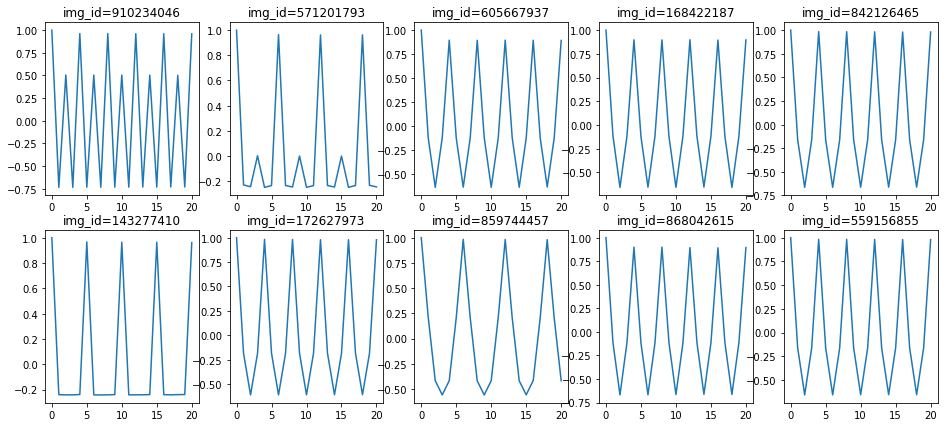

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(16, 7))
axs = axs.flatten()
for ax, img_id in zip(axs, cycled_ids):
    ax.plot(history[img_id])
    ax.set_title("img_id=%s"%img_id)

Графики первых 40 пикселей: изменение внесенное в картинку и произведение оценки параметра альфа на эмбеддинг слова соответсвенно.

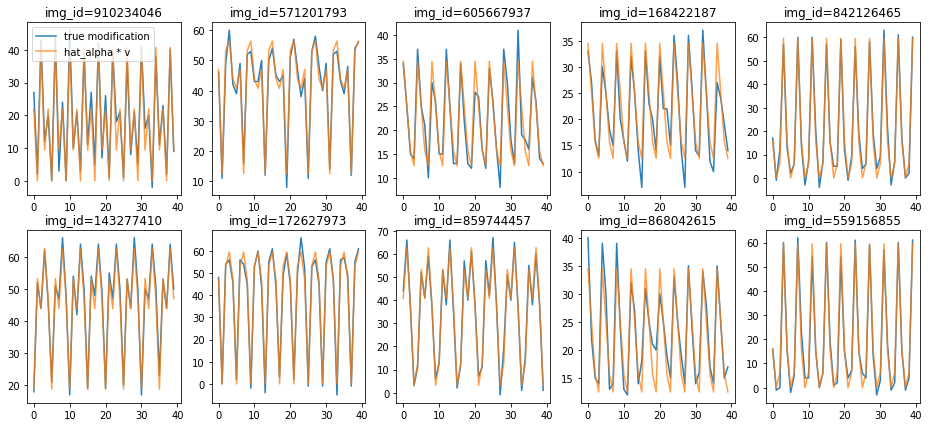

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(16, 7))
axs = axs.flatten()
for ax, img_id in zip(axs, cycled_ids):
    x, y = get_object(img_id, img_names, img_dir)
    ax.plot(x.flatten()[:40], alpha=0.95, label='true modification', color='C0')
    ax.plot(hat_alpha * y[:40], alpha=0.75, label='hat_alpha * v', color='C1')
    ax.set_title("img_id=%s"%img_id)
axs[0].legend(loc=2);

Видим, что эмпирически оценка неплоха. 

Но так же заметим, в данных даже смоделированных указанным образом (согласно алгоритму) были шумы, что привело к несоответствию некотрых пиков для отдельных картинок. Данные выбросы естественно ухудшают нашу оценку, которая предполагала, что все-таки тут есть явная детерминированность и нет шумов. 

Тогда построим простую регрессию векторного представления слова на соответсвующее изменение, внесенное в картинку. То есть модель имеет вид:
> $\text{delta_img} = \alpha \cdot \text{vect_phrase} + \epsilon$

In [11]:
cycled_ids = np.array(img_ids)[has_cycle]
xs, ys = [], []
for img_id in cycled_ids:
    x, y = get_object(img_id, img_names, img_dir)
    xs += list(x.flatten())
    ys += list(y)

In [12]:
ols = sm.OLS(xs, ys).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          5.993e+06
Date:                Sat, 16 May 2020   Prob (F-statistic):                        0.00
Time:                        14:46:23   Log-Likelihood:                     -1.0155e+05
No. Observations:               40960   AIC:                                  2.031e+05
Df Residuals:                   40959   BIC:                                  2.031e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.1338      0.001   2447.966      0.000       3.131       3.136
==============================================================================
Omnibus:                    22477.482   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1869239.399
Skew:                          -1.778   Prob(JB):                         0.00
Kurtosis:                      35.903   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

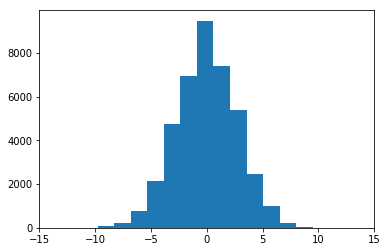

In [13]:
res = ols.resid
plt.hist(res, bins = 50);
plt.xlim(-15, 15);

С отстатками все хорошо, распредление соответсвует нашим ожиданиям. 

Тогда из МНК получили, нашу окончательную оценку. 

In [14]:
hat_alpha = 3.1338

Само значение оценки изменилось не сильно на самом деле. Но далее придерживаемся именно этой оценки. 
(Впрочем даже старая оценка приводит к верному ответу, в данном случае и так все работало.)

In [15]:
orig_img = np.array(io.imread('images_full/original_test.bmp').astype(int))
mod_img = np.array(io.imread('images_full/modified_test.bmp').astype(int))
delta_img = mod_img - orig_img

In [16]:
#vec2phrase
''.join([chr(97+int(np.round(x))) for x in delta_img.flatten() / hat_alpha])

'wheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemonetlebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemonexlebowskiwheresthemoneylebowskirheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthemoneylebowskiwheresthe

__WHERE'S THE MONEY LEBOWSKI?!__

----
Выводы.
* Задача отбора картинок, изменение которых генерировалось алгоритмом, сведена к анализу ряда на соответствие белому шуму. Проверялась соответсвующая нулевая гипотеза тестом Лъюинга-Бокса для лагов, отвечающих локальным максимумам ACF. Введена поправка на множественное тестирование гипотез.
* На основе отобранных изображений, был оценен параметр $\alpha$ алгоритма путем построения модели линейной регрессии, отвечающей формуле генерации. Эмпирически оценена приемлемость качества оценки. 
* С помощью данной оценки параметра восстановлена контрольная фраза, зашифрованная в тесте: _wheresthemoneylebowski_.
